# PISA 2022 analysis

To start the notebook, run "jupyter notebook".

Some basic analysis on school student performance in PISA tests across OECD countries. in particular we examine
- the effect of GDP per capita
- Culture
- Gender
- etc.

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Loading data
data source: https://www.oecd-ilibrary.org/education/pisa-2022-results-volume-i_53f23881-en

In [58]:
df_score__raw = pd.read_csv("data/pisa_2022.csv")
df_score__raw

,category,country,gender,score
0,math,Australia,girl,481
1,math,Australia,boy,493
2,reading,Australia,girl,509
3,reading,Australia,boy,487
4,science,Australia,girl,506
...,...,...,...,...
217,math,United States,boy,471
218,reading,United States,girl,515
219,reading,United States,boy,493
220,science,United States,girl,496


In [59]:
df_inequality__raw = pd.read_csv("data/gender_equality_data.csv")
df_inequality__raw

,HDI rank,Country,Gender Inequality Index: Value,Gender Inequality Index: Rank,Maternal mortality ratio (deaths per 100000 live births),Adolescent birth rate (births per 1000 women ages 15–19),Share of seats in parliament (% held by women),secondary education (% ages 25 and older) Female,secondary education (% ages 25 and older) Male,Labour force participation rate (% ages 15 and older) Female,Labour force participation rate (% ages 15 and older) Male
0,1,Switzerland,0.018,3,5.0,2.2,39.8,96.9,97.5,61.7,72.7
1,2,Norway,0.016,2,2.0,2.3,45.0,99.1,99.3,60.3,72.0
2,3,Iceland,0.043,8,4.0,5.4,47.6,99.8,99.7,61.7,70.5
3,5,Australia,0.073,19,6.0,8.1,37.9,94.6,94.4,61.1,70.5
4,6,Denmark,0.013,1,4.0,1.9,39.7,95.1,95.2,57.7,66.7
...,...,...,...,...,...,...,...,...,...,...,...
59,63,Mauritius,0.347,82,61.0,24.6,20.0,64.4,70.8,43.4,70.4
60,63,Serbia,0.131,36,12.0,14.9,39.2,88.6,95.3,46.6,62.3
61,66,Thailand,0.333,79,37.0,32.7,13.9,47.6,51.7,59.0,75.0
62,88,Colombia,0.424,102,83.0,59.0,19.6,58.9,56.5,52.2,78.0


## Preprocess data - scores

math has 95%-conf performance delta: -19.58 to 1.69


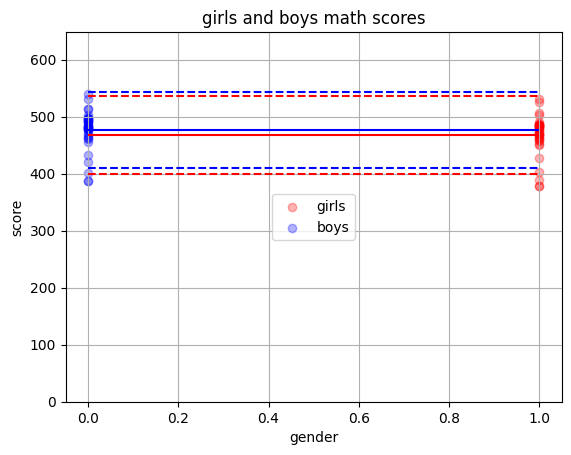

reading has 95%-conf performance delta: 6.54 to 42.11


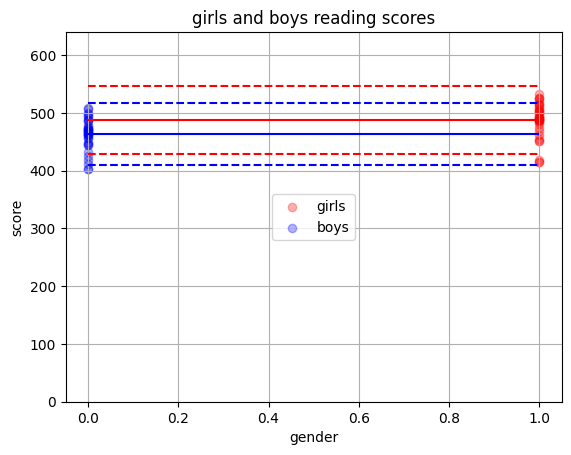

science has 95%-conf performance delta: -15.44 to 15.92


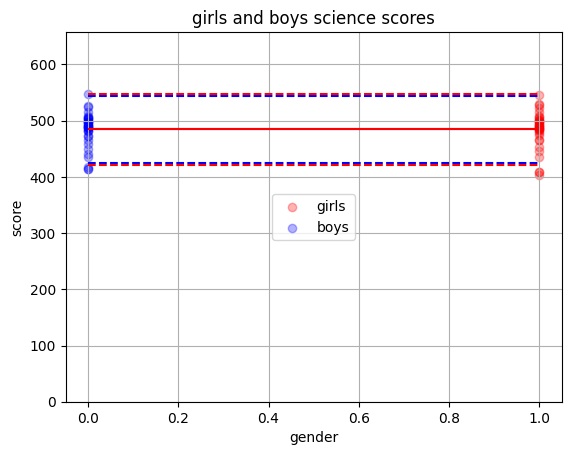

In [60]:
df_score = df_score__raw.copy()

df_score["is_girl"] = (df_score["gender"] == "girl").astype(int)
df_score = df_score.drop(columns=["gender"])
for subject in ["math", "reading", "science"]:
    
    df_score__subject = df_score[df_score["category"] == subject].copy()
    df_score__subject_girl =  df_score__subject[df_score__subject["is_girl"] == 1].copy()
    df_score__subject_boy =  df_score__subject[df_score__subject["is_girl"] == 0].copy()
    df_score__subject_girl["score__girl"] = df_score__subject_girl["score"]
    df_score__subject_boy["score__boy"] = df_score__subject_boy["score"]

    df_score__subject_diff = df_score__subject_girl.copy().merge(
        df_score__subject_boy.copy(), on=["country", "category"], how="inner")
    df_score__subject_diff["score_diff"] = df_score__subject_diff["score__girl"] - \
        df_score__subject_diff["score__boy"]

    mean = df_score__subject_diff["score_diff"].mean()
    std = df_score__subject_diff["score_diff"].std()
    lb = mean - 1.97 * std
    ub = mean + 1.97 * std
    print(f"{subject} has 95%-conf performance delta: {lb:.2f} to {ub:.2f}")


    
    plt.figure()
    plt.title(f"girls and boys {subject} scores")
    plt.scatter(x=df_score__subject_girl["is_girl"], y=df_score__subject_girl["score"],
                color="red", label="girls", alpha=0.3)
    plt.scatter(x=df_score__subject_boy["is_girl"], y=df_score__subject_boy["score"],
                color="blue", label="boys", alpha=0.3)
    plt.legend(loc="center")
    plt.hlines(df_score__subject_boy["score"].mean(), 0, 1, color="blue",ls="-")
    plt.hlines(df_score__subject_girl["score"].mean(), 0, 1, color="red",ls="-")

    plt.hlines(df_score__subject_boy["score"].mean() +\
        df_score__subject_boy["score"].std() * 1.97, 0, 1, color="blue", ls="--")
    plt.hlines(df_score__subject_boy["score"].mean() -\
        df_score__subject_boy["score"].std() * 1.97, 0, 1, color="blue", ls="--")

    plt.hlines(df_score__subject_girl["score"].mean() +\
        df_score__subject_girl["score"].std() * 1.97, 0, 1, color="red", ls="--")
    plt.hlines(df_score__subject_girl["score"].mean() - \
        df_score__subject_girl["score"].std() * 1.97, 0, 1, color="red", ls="--")

    plt.ylim(0, max(df_score__subject_girl["score"].max(), df_score__subject_boy["score"].max()) * 1.2)
    plt.xlabel("gender")
    plt.ylabel("score")
    plt.grid()
    plt.show()
    

## Preprocess data - inequality

In [61]:
df_inequality = df_inequality__raw.copy()
df_inequality = df_inequality[["Country","Gender Inequality Index: Value"]]

df_inequality.rename(columns={"Country": "country"}, inplace=True)
df_inequality.rename(columns={"Gender Inequality Index: Value": "inequality_index"}, inplace=True)

df_inequality

,country,inequality_index
0,Switzerland,0.018
1,Norway,0.016
2,Iceland,0.043
3,Australia,0.073
4,Denmark,0.013
...,...,...
59,Mauritius,0.347
60,Serbia,0.131
61,Thailand,0.333
62,Colombia,0.424


## Combine school score and gender inequality data

### Q1: Do girls (and separately boys) scores correlate with inequality index in each subject?
Make a scatter graph for each subject for boys and girls (6 graphs) with test scores on the y-axis and inequality index on the x-axis.

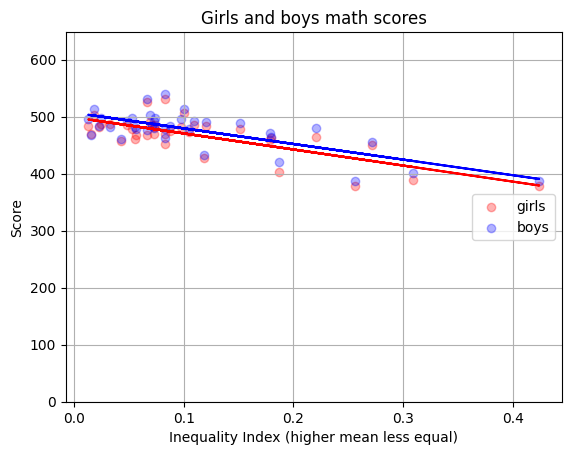

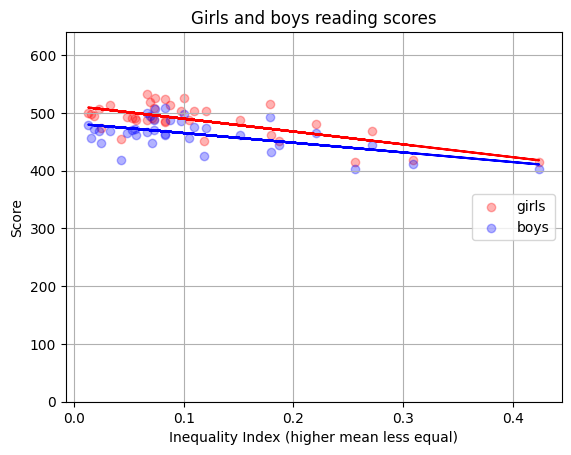

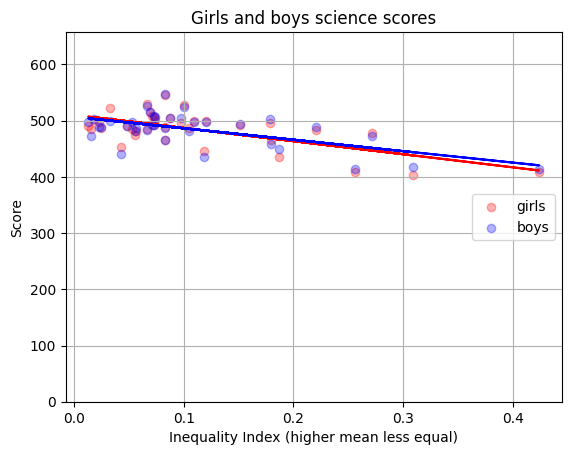

In [72]:
df_combined = df_score.copy().merge(
        df_inequality.copy(), on=["country"], how="inner")

for subject in ["math", "reading", "science"]:
    # Make separate boys and girls tables
    df_combined__subject = df_combined[df_combined["category"] == subject].copy()
    df_combined__subject_girl =  df_combined__subject[df_combined__subject["is_girl"] == 1].copy()
    df_combined__subject_boy =  df_combined__subject[df_combined__subject["is_girl"] == 0].copy()

    # Rename columns for scores
    df_combined__subject_girl.rename(columns={"score": "score_girl"}, inplace=True)
    df_combined__subject_boy.rename(columns={"score": "score_boy"}, inplace=True)

    # Merge the boys and girls tables
    df_combined__subject_diff = df_combined__subject_girl.copy().merge(
        df_combined__subject_boy.copy(), on=["country", "category", "inequality_index"], how="inner")

    plt.figure()
    plt.title(f"Girls and boys {subject} scores")
    plt.scatter(x=df_combined__subject_diff["inequality_index"], y=df_combined__subject_diff["score_girl"],
                color="red", label="girls", alpha=0.3)
    plt.scatter(x=df_combined__subject_diff["inequality_index"], y=df_combined__subject_diff["score_boy"],
                color="blue", label="boys", alpha=0.3)

    for gender_score in ["score_girl", "score_boy"]:
        x = np.array(df_combined__subject_diff["inequality_index"])
        y = np.array(df_combined__subject_diff[gender_score])
        A = np.vstack([x, np.ones(len(x))]).T
        m, c = np.linalg.lstsq(A, y, rcond=None)[0]
        colour =  'r' if gender_score == "score_girl" else 'b'
        plt.plot(x, m*x + c, colour)

    
    plt.ylim(0, max(df_combined__subject_diff["score_girl"].max(), df_combined__subject_diff["score_boy"].max()) * 1.2)
    plt.legend(loc="right")
    plt.xlabel("Inequality Index (higher mean less equal)")
    plt.ylabel("Score")
    plt.grid()
    plt.show()

    

    